In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os, sys

In [2]:
import order_parameter_dynamics as opd

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from chainer import Chain, ChainList, cuda, gradient_check, Function, Link, optimizers, serializers, utils, Variable, datasets, using_config
from chainer import functions as F
from chainer import links as L

import scipy.special as spsp
class Func_erf2(Function): # (erf(x/sqrt(2)))   
    def forward_cpu(self, x):
        sq2 = x[0].dtype.type(np.sqrt(2.0))
        self.y = utils.force_array(spsp.erf(x[0]/sq2))
        return self.y,
    def backward_cpu(self, x, gy):
        sq2pi = x[0].dtype.type(np.sqrt(2.0/np.pi))
        two = x[0].dtype.type(2.0)
        return utils.force_array(gy[0]*sq2pi*np.exp(-x[0]*x[0]/two)),
def func_erf2(x):
    return Func_erf2()(x)

def is_integer_type(typ):
    try:
        xp = cuda.cupy
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64,
                xp.int8, xp.int16, xp.int32, xp.int64,
                xp.uint8, xp.uint16, xp.uint32, xp.uint64,]
    except AttributeError:
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64]



class MLP(ChainList):
    def __init__(self, ls, nobias, act, opt, last_activation):
        self.ls = ls
        self.l = []
        for i in range(len(ls)-1):
            self.l.append(L.Linear(ls[i], ls[i+1], nobias=nobias))
        super(MLP, self).__init__(*self.l)
        self.act = act
        self.opt = opt
        self.last_activation = last_activation
        if self.opt is not None: self.opt.setup(self)
        self.lossfrac = np.zeros(2)
        self.accfrac = np.zeros(2)
    def __call__(self, x, mode='train'): # Variable受け取ってVariable返す
        with using_config('train', mode=='train'):
            for i in range(len(self.l)):
                x = self.l[i](x)
                if i+1<len(self.l) or self.last_activation : x = self.act(x)
        return x
    def update(self, x, t, mode='train'):  # Variable受け取ってVariable返す
        bs = x.shape[0]
        y = self(x, mode=mode)
        if is_integer_type(t.data.dtype):
            if 1: # 分類 (softmax_cross_entropy)
                loss = F.softmax_cross_entropy(y, t)
                acc = np.count_nonzero(np.argmax(y.data,axis=1)==t.data)
            elif 0: # 二値分類 (sigmoid_cross_entropy)
                loss = F.sigmoid_cross_entropy(y, t) # y and t has same dimension
                acc = np.count_nonzero((y.data>0).astype(np.int32)==t.data)
            else:
                raise ValueError
        else:
            # 回帰 (squared)
            loss = 0.5 * F.sum((y - t)**2) / bs
            acc = 0

        # loss は bs で割られたスカラーになっている．はず
        if mode=='train':
            self.cleargrads()
            loss.grad = np.ones(loss.shape, dtype=np.float32)
            loss.backward()
            self.opt.update()
        elif mode=='test':
            pass
        else:
            raise ValueError
        self.lossfrac += np.array([np.sum(loss.data) * bs, bs])
        self.accfrac += np.array([acc, bs])
        return loss
    def aveloss(self, clear=False):
        ret = self.lossfrac[0]/self.lossfrac[1]
        if clear: self.lossfrac = np.zeros(2)
        return ret
    def aveacc(self, clear=False):
        ret = (0.+self.accfrac[0])/self.accfrac[1]
        if clear: self.accfrac = np.zeros(2)
        return ret
    def W(self, idx):
        return self.l[idx].W.data

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
def average(ary, bin_width):
    return np.array([np.mean(ary[i:i+bin_width]) for i in range(0,len(ary),bin_width)])

In [5]:
def overlap(v1, v2):
    return np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

In [6]:
def get_mnist_lambdas():
    train, test = datasets.get_mnist()
    ary = np.array([data[0] for data in train]).astype(np.float64) # (60000, 784)
    return np.sort(np.linalg.svd(ary, compute_uv=False) ** 2) / ary.shape[0]
mnist_lambdas = get_mnist_lambdas()

In [35]:
# 二層 erf2 パーセプトロンの SGD 学習
# act, act_string = F.identity, 'id'
act, act_string = func_erf2, 'erf'

N = 100
eta = 0.1
mdl = MLP(ls=[N,1], nobias=True, act=act, opt=optimizers.SGD(lr=eta/N), last_activation=True)
mdl_t = MLP(ls=[N,1], nobias=True, act=act, opt=None, last_activation=True)
nb_iter = 100 * N

lambdas = mnist_lambdas[0:700:7] # overlap of ^1 and ^2 ==  0.919 結構ずれる
# lambdas = np.array([0.] * 70 + [1.] * 20 + [1.2] * 10) # overlap of ^1 and ^2 ==  0.995 ほぼずれない！ 
# lambdas = np.ones(N) # overlap of ^1 and ^2 ==  1
# lambdas = np.array([0.1+0.7*i/N for i in range(N)])  # overlap of ^1 and ^2 ==  0.968 ちょっとずれる
# lambdas = np.logspace(-1, 1, N)
print('overlap of lambdas and lambdas**2:  ', overlap(lambdas, lambdas*lambdas))
cov = np.diag(lambdas)
cov_pow = {i: np.diag([l**i for l in lambdas]) for i in range(-10, 11)}

bs = 100


Ls = np.array([np.nan])
Qs = { i : np.zeros(0) for i in range(-10,11) }
Rs = { i : np.zeros(0) for i in range(-10,11) }
T = { i : np.dot(np.dot(mdl_t.W(0), cov_pow[i],), mdl_t.W(0).T)[0,0] for i in range(-10,11)}
for it in tqdm(range(nb_iter)):
    for i in range(-10, 11):
        current_Q = np.dot(np.dot(mdl.W(0), cov_pow[i],), mdl.W(0).T)[0,0]
        current_R = np.dot(np.dot(mdl.W(0), cov_pow[i],), mdl_t.W(0).T)[0,0]
        Qs[i] = np.r_[Qs[i], current_Q]
        Rs[i] = np.r_[Rs[i], current_R]

    xi = Variable(np.random.multivariate_normal(np.zeros(N), cov, [bs]).astype(np.float32))
    t = mdl_t(xi)
    lo = mdl.update(xi, t, mode='train')
    Ls = np.r_[Ls, lo.data]

Ls_sgd = Ls

overlap of lambdas and lambdas**2:   0.9191934178721529


/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in double_scalars


/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


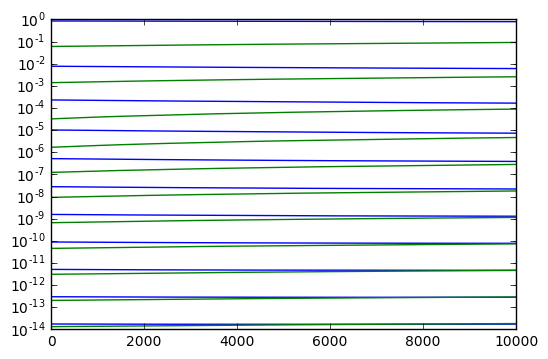

In [36]:
loss_curve = average(Ls, 1)
# plt.plot(np.arange(len(loss_curve)), loss_curve)
for power in range(-10, 11):
    plt.plot(np.arange(len(Qs[power])), Qs[power], color='b')
    plt.plot(np.arange(len(Rs[power])), Rs[power], color='g')
plt.yscale('log')
plt.show()

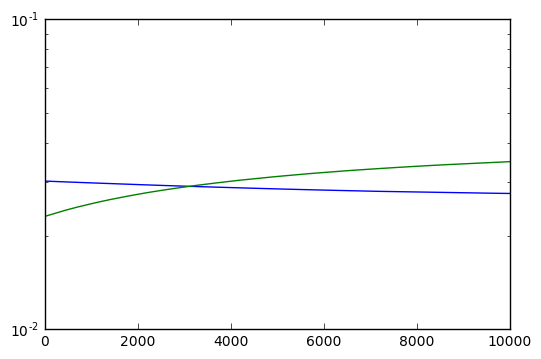

In [37]:
loss_curve = average(Ls, 1)
# plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.plot(np.arange(len(Qs[2])), Qs[2]/Qs[1], color='b')
plt.plot(np.arange(len(Rs[2])), Rs[2]/Rs[1], color='g')
plt.yscale('log')
plt.show()

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


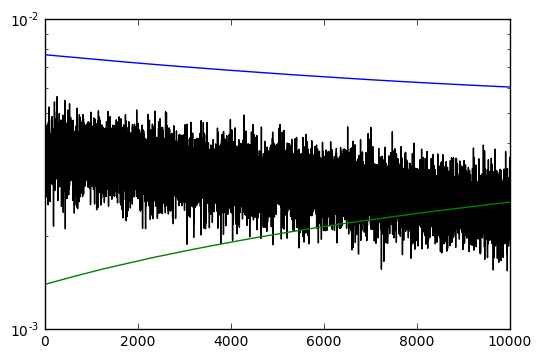

In [38]:
loss_curve = average(Ls, 1)
plt.plot(np.arange(len(loss_curve)), loss_curve, color='k')
power = +1
plt.plot(np.arange(len(Qs[power])), Qs[power], color='b')
plt.plot(np.arange(len(Rs[power])), Rs[power], color='g')
plt.yscale('log')
plt.show()

In [39]:
# Q^{(2)}やR^{(2)} を
# Q^{(1)}*max(lambda)やR^{(1)}*max(lambda)で近似してみよう．
# あるいは比例定数部分を lambdaの2次モーメント/1次モーメント として近似してみよう．

In [40]:
print(T[2]/T[1], max(lambdas), np.sqrt(T[4]/T[2]))

0.03563340271775616 0.06182577161546561 0.052224438167426036


In [41]:
# opd を使う．
# coef = [np.max(lambdas), np.mean(lambdas**2)] # 重み
# coef = [np.mean(lambdas**2)/np.mean(lambdas), np.mean(lambdas**2)] 
# coef = [np.sqrt(np.mean(lambdas**4)/np.mean(lambdas**2)), np.mean(lambdas**2)] 
coef = [T[2]/T[1], np.mean(lambdas**2)] 
# coef = [1, 1]
print(coef)

start_it = 0

op = opd.opd_inf_1(
    np.array([[Qs[1][start_it], Rs[1][start_it]],[Rs[1][start_it], T[1]]]), eta=eta, act=act_string, coef=coef
)
oplog = np.zeros([nb_iter+1,2,2]) + np.nan
oplosslog = np.zeros([nb_iter+1]) + np.nan
oplog[start_it,:,:] = op.QRT.copy()
oplosslog[start_it] = op.eps()
for it in range(start_it,nb_iter//N):
    op.update()
    oplog[1+it,:,:] = op.QRT.copy()
    oplosslog[1+it] = op.eps()

[0.03563340271775616, 0.00020541671395071437]
eta:  0.1 N:  100


/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


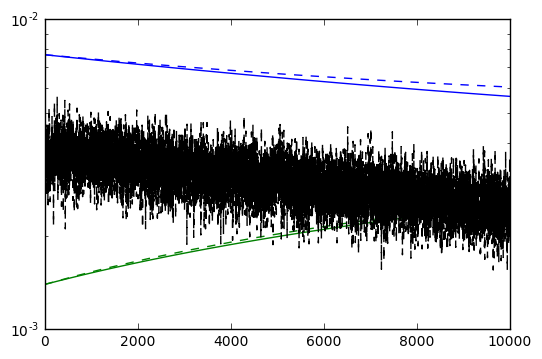

In [42]:
plt.plot(np.arange(len(oplog))*N, oplog[:,0,0], color='b')
plt.plot(np.arange(len(oplog))*N, oplog[:,0,1], color='g')
plt.plot(np.arange(len(oplog))*N, oplosslog, color='k')
plt.plot(np.arange(len(Qs[1])), Qs[1], linestyle='--', color='b')
plt.plot(np.arange(len(Rs[1])), Rs[1], linestyle='--', color='g')
plt.plot(np.arange(len(Ls)), Ls, linestyle='--', color='k')
plt.yscale('log')
plt.show()

In [ ]:
%autoreload